# Case Study 2 - Sheep Femur Trabecular Bone

CRBS VectoRose Bootcamp

Benjamin Z. Rudski <benjamin.rudski@mail.mcgill.ca>

August 6, 2025

In the previous case study notebook, we saw how to use VectoRose for analysing pure orientations. We constructed spherical orientation histograms and filtered based on orientation.

Now, we're going to kick things up a notch.

What if your data aren't pure directions or orientations? What if your vectors have some sort of **magnitude** associated with them? How can we visualise these quantities?

Stay tuned to find out!

In this notebook, we'll explore these additional functionalities of VectoRose through the analysis of trabecular bone anisotropy in a sheep femur.

## Outline

Before we begin, here's the outline of the material we'll cover in this notebook.

1. Sample Data
2. Review: Getting Started
3. Preparing the Sphere
4. Constructing Magnitude Histograms
5. Constructing Bivariate Nested Spherical Histograms
6. Animating Bivariate Histograms
7. Constructing Conditional Histograms
8. Note on Computing Statistics

After following this notebook (in addition to the previous one), you will be familiar with almost all the basic functionality of VectoRose. You will then be able to apply VectoRose to analyse your data, regardless of the sample under study or the data acquisition method used.

## Sample Data

Bones are not fully-filled structures. Inside bone, there is a network of dense, interconnected struts, known as *trabeculae*. 

In this example, we'll focus on the trabecular bone in the femur of a mature sheep. Trabecular bone isn't found throughout the entire bone. Instead, in long bones, like the femur, it's found at the two ends, or *epiphyses*.

Through the worked example, we'll analyse the trabecular bone in the *proximal* epiphysis, the end that is closest to the hip. Later, you'll be able to analyse the trabecular bone in the *distal* epiphysis, which is part of the knee.

The entire sheep femur is a very, very big dataset. Instead of looking at the entire volume here, we'll look at two different meshes for a start. We'll look at the exterior shell of the femur, just to get a feel for the bone, and then, we'll look at some simplified cubes of trabecular bone to understand this structure a bit better.

In [1]:
from IPython.display import Video

Video("../assets/CaseStudy2/SheepFemur.mp4", width=720)

> 📝 **Note**\
> We will analyse larger volumes of the bone to understand the trabecular architecture. This simplification was just for the purposes of illustration.

### Trabecular Anisotropy Overview

One last thing that we need to go over is... well... the actual vector collection.

The bone is just an image! Where do the vectors come in? Well, we'll look at **trabecular anisotropy**, which is a measurement of the local co-alignment of the trabecular struts.

This quantity provides us **two** pieces of information:

1. the dominant local orientation of trabeculae in a certain volume
2. the degree of co-alignment of the trabeculae

Trabecular anisotropy can be thought of as a **vector field**; at each spatial location, we have a vector pointing in the dominant local orientation with a magnitude corresponding to the degree of co-alignment.

So, in this case, we don't just want to look at the local orientations! We also want to consider the associated magnitudes.

Let's see how to take care of this type of data using VectoRose.

## Review: Getting Started

As we did before, we need to start by loading our vector data into Python using VectoRose, and we need to perform some data cleaning.

Let's do all the steps in one block this time.

In [2]:
vectors_path = "../assets/CaseStudy2/MatureSheepFemur_Proximal_S750_R1500_SMOOTH1_EIG_MASKED.npy"

# Your code here for vector loading and preprocessing

import vectorose as vr

vectors = vr.io.import_vector_field(vectors_path)
vectors = vr.util.remove_zero_vectors(vectors)
vectors = vr.util.convert_vectors_to_axes(vectors)

duplicated_vectors = vr.util.create_symmetric_vectors_from_axes(vectors)

vectors

array([[ 0.05307839,  0.02543059,  0.00101497,  0.27175105, -0.31369656,
         0.113892  ],
       [ 0.05382839,  0.02543059,  0.00101497,  0.18977632, -0.25979963,
         0.158821  ],
       [ 0.05457839,  0.02543059,  0.00101497,  0.11062115, -0.26995078,
         0.16979323],
       ...,
       [ 0.03807839,  0.03518059,  0.06701497, -0.0533663 , -0.07755541,
         0.70392364],
       [ 0.03882839,  0.03518059,  0.06701497, -0.05921967, -0.09034572,
         0.74328053],
       [ 0.03957839,  0.03518059,  0.06701497, -0.09140608, -0.09448492,
         0.7715621 ]], shape=(61898, 6))

## Preparing the Sphere

Now, we need to create a sphere to build our histograms. Like last time, we'll use a [`FineTregenzaSphere`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/tregenza_sphere/index.html#vectorose.tregenza_sphere.FineTregenzaSphere).

But we'll do something different when we create it!

Since we want to look at the magnitude distribution also, we're going to create more than one shell. Let's consider 10 magnitude bins. When creating the `FineTregenzaSphere`, we need to set `number_of_shells=10`.

By default, the highest and lowest bin edges will be determined based on the magnitudes present in the data. We can change these bounds using the `magnitude_range` parameter. In the case of trabecular anisotropy, values can only be in the interval `[0, 1]`, where an anisotropy of 0 represents structures with no co-alignment and 1 represents structures with perfect co-alignment. We'll use these as the bounds for our `magnitude_range`, as well.

In [3]:
# Your code here to create the Tregenza sphere

my_sphere = vr.tregenza_sphere.FineTregenzaSphere(
    number_of_shells=10, magnitude_range=(0, 1)
)

Now, we have a sphere that we can use to bin by both magnitude and orientation!

Like before, the next step is to assign the vectors to histogram bins. Since our sphere has multiple magnitude shells, the [`assign_histogram_bins`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.assign_histogram_bins) method takes care of both the magnitude and the orientation. This method produces two outputs:

1. the `DataFrame` with the bin assignments
2. the edges of the magnitude bins

We haven't seen the second returned value yet, but this is important. It tells us where each magnitude bin starts and ends. These will be very important when we want to plot our magnitude histograms.

So, let's now assign our vectors to bins!

In [4]:
# Your code here to assign vectors to their bins

labelled_vectors, magnitude_bin_edges = my_sphere.assign_histogram_bins(
    duplicated_vectors
)

print("Magnitude bin edges:")
print(magnitude_bin_edges)

labelled_vectors

Magnitude bin edges:
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


,x,y,z,phi,theta,magnitude,shell,ring,bin
0,0.053078,0.025431,0.001015,74.654897,139.098063,0.430378,4,22,64
1,0.053828,0.025431,0.001015,63.726972,143.852923,0.358797,3,19,62
2,0.054578,0.025431,0.001015,59.800255,157.717031,0.337550,3,18,66
3,0.052328,0.026181,0.001015,84.746284,148.279409,0.454628,4,25,71
4,0.053078,0.026181,0.001015,84.277207,142.456108,0.326447,3,25,68
...,...,...,...,...,...,...,...,...,...
123791,0.036578,0.035181,0.067015,172.764706,18.838002,0.737909,7,51,0
123792,0.037328,0.035181,0.067015,173.046994,25.732937,0.711181,7,51,1
123793,0.038078,0.035181,0.067015,172.382487,34.532070,0.710191,7,50,2
123794,0.038828,0.035181,0.067015,171.730819,33.243979,0.751089,7,50,2


## Constructing Magnitude Histograms

At first, the table above looks quite similar to what we had last time... but notice that the **`shell`** column now doesn't contain all zeros. We have a variety of different values in there.

The `shell` column contains the bin indices for the magnitude histogram! We're going to use these bin assignments to construct a magnitude histogram.

Using VectoRose, we can easily collect all these bin assignments into a histogram using the method [`construct_marginal_magnitude_histogram`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.construct_marginal_magnitude_histogram) on our `FineTregenzaSphere`.

Let's see what this produces.

In [5]:
# Your code here to compute the magnitude histogram

magnitude_histogram = my_sphere.construct_marginal_magnitude_histogram(
    labelled_vectors
)

magnitude_histogram.to_frame()

,0
shell,
0,0.000840
1,0.016333
2,0.065059
3,0.154189
4,0.209457
5,0.195628
6,0.141022
7,0.101376
8,0.071230


We can see that we now have the fraction of vectors that are associated with each magnitude histogram bin.

> 💡 **Tip**\
> Interested in counts instead of frequencies? Set `return_fraction=False` when calling this method, and you'll get a histogram based on counts instead.

This is great... but we want a nice bar plot, not just a list of numbers.

Thankfully, using [`vr.plotting.produce_1d_scalar_histogram`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/plotting/index.html#vectorose.plotting.produce_1d_scalar_histogram), we can get our histogram plot.

This function requires the histogram data, as well as those bin boundaries we computed before.

Let's now visualise our magnitude histogram!

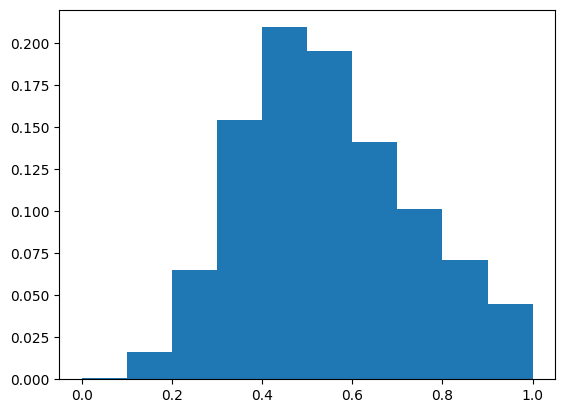

In [6]:
# Your code here to visualise the magnitude histogram

ax = vr.plotting.produce_1d_scalar_histogram(
    magnitude_histogram,
    magnitude_bin_edges
)

This plot is generated with [Matplotlib](https://matplotlib.org/), and so, we can apply all the usual Matplotlib customisations to it, like adding titles and axis labels.

Another helpful thing we can do is set the *y*-axis to use a logarithmic scale by passing `log=True` to the function call.

Let's see what happens for these data.

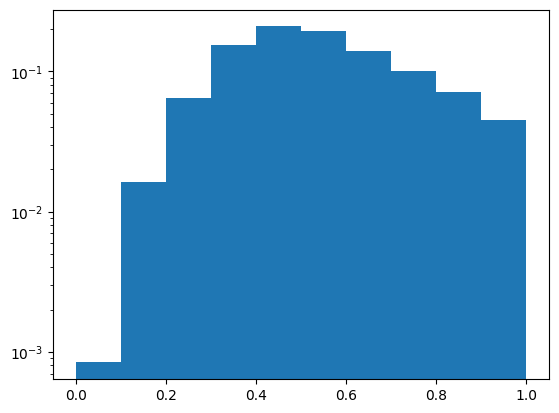

In [7]:
# Your code here to construct a log histogram

ax = vr.plotting.produce_1d_scalar_histogram(
    magnitude_histogram,
    magnitude_bin_edges,
    log=True,
)

Now we successfully have a log-scale plot!

## Constructing Bivariate Histograms

So, by now we've seen how to construct histograms of just orientation or just magnitude... but what if we want to see which orientations are more common for high magnitudes, or for low magnitudes, what can we do?

Well, we can construct **bivariate histograms** of magnitude and orientation. These histograms show a frequency value for each **combination** of magnitude and orientation.

To visualise these combinations, we rely on **nested spherical histograms**. Each level in the spherical histogram corresponds to a different range of magnitude values.

### Computing Bivariate Histograms

As always, before we can visualise a histogram, we need to compute the bin frequencies. For the bivariate histograms, we do this using the [`construct_histogram`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.construct_histogram) method on our `FineTregenzaSphere`.

As usual, if we want to work with counts instead of frequencies, we can pass `return_fraction=False`.

In [8]:
# Your code here to compute the bivariate histogram

bivariate_histogram = my_sphere.construct_histogram(labelled_vectors)

bivariate_histogram.to_frame()

frequency
shell ring bin           
0     0    0     0.000000
      1    0     0.000000
           1     0.000000
           2     0.000000
           3     0.000000
...                   ...
9     52   2     0.000283
           3     0.000242
           4     0.000275
           5     0.000145
      53   0     0.000291

[58060 rows x 1 columns]

We now have something that looks similar to the orientation histogram, but with a twist. We now have an extra layer of indexing. We see the frequency associated with each ring and bin in each shell.

### Visualising the Bivariate Histogram

Now, to visualise the histogram, we'll once again use the [`SpherePlotter`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/plotting/index.html#vectorose.plotting.SpherePlotter). But first, we need to provide histogram meshes.

To construct histogram meshes for the bivariate histogram, we must pass the histogram data to the method [`create_histogram_meshes`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.create_histogram_meshes). 

This method produces one spherical mesh for each histogram shell.

There is one other required parameter: the magnitude bins. These bin bounds are used to set the size of the produced spheres:

* If the bin edges found above are provided, then they are used to determine the radius of each sphere. The sphere radii correspond to the **upper bound** of the bins.
* If `None` is provided, then the sphere all have the common radius of one.

Let's start by providing the bin edges.

In [9]:
# Your code here to create the histogram meshes

shell_meshes = my_sphere.create_histogram_meshes(
    bivariate_histogram, magnitude_bin_edges
)

shell_meshes

[PolyData (0x12ed7b160)
   N Cells:    5806
   N Points:   10619
   N Strips:   0
   X Bounds:   -1.000e-01, 1.000e-01
   Y Bounds:   -9.998e-02, 1.000e-01
   Z Bounds:   -9.997e-02, 9.997e-02
   N Arrays:   4,
 PolyData (0x12ed7aaa0)
   N Cells:    5806
   N Points:   10619
   N Strips:   0
   X Bounds:   -2.000e-01, 2.000e-01
   Y Bounds:   -2.000e-01, 2.000e-01
   Z Bounds:   -1.999e-01, 1.999e-01
   N Arrays:   4,
 PolyData (0x12eda8400)
   N Cells:    5806
   N Points:   10619
   N Strips:   0
   X Bounds:   -3.000e-01, 3.000e-01
   Y Bounds:   -3.000e-01, 3.000e-01
   Z Bounds:   -2.999e-01, 2.999e-01
   N Arrays:   4,
 PolyData (0x12edab9a0)
   N Cells:    5806
   N Points:   10619
   N Strips:   0
   X Bounds:   -4.000e-01, 4.000e-01
   Y Bounds:   -3.999e-01, 4.000e-01
   Z Bounds:   -3.999e-01, 3.999e-01
   N Arrays:   4,
 PolyData (0x12ed7a1a0)
   N Cells:    5806
   N Points:   10619
   N Strips:   0
   X Bounds:   -5.000e-01, 5.000e-01
   Y Bounds:   -4.999e-01, 5.000e-01


We can now see that we have a number of meshes that have been produced. If we look at the bounds for each in their descriptions, we see that they get progressively larger.

Now, let's use the `SpherePlotter` to visualise these histogram shells.

> ⚠️ **Caution**\
> As always, don't forget to call `SpherePlotter.produce_plot` before trying to `show` the plot.

In [10]:
# Your code here to create the sphere plotter

my_plotter = vr.plotting.SpherePlotter(shell_meshes)
my_plotter.produce_plot()
my_plotter.show()

Widget(value='<iframe src="http://localhost:57487/index.html?ui=P_0x12ee38280_0&reconnect=auto" class="pyvista…

While this plot initially looks pretty similar to the orientation histogram, you may notice an important difference. At the top, instead of having a single slider, controlling the opacity of the histogram, we now have three sliders.

Try playing with each one. You'll notice that:

* The left slider controls which shell is currently active.
* The central slider controls the opacity of this active shell.
* The right slider controls the opacity of all other inactive shells.

At the extreme case, if the central slider is set to `1` and the right slider is set to `0`, we only have one shell visible at a time. The visible shell is determined by the left slider.

So, we can get a pretty clear view of the vector distribution by flipping through these different shells.

Wouldn't it be nice if there were an easier way to do this?

## Animating Bivariate Histograms

In addition to the rotation animations we covered in the previous notebook, we can also create bivariate histogram shell animations. In these animations, each frame contains a different spherical shell.

To create a shell animation, we call the method [`produce_shells_video`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/plotting/index.html#vectorose.plotting.SpherePlotter.produce_shells_video) on the `SpherePlotter`.

In [21]:
# Your code here to produce a shell animation video

my_plotter.produce_shells_video(
    "shells_animation.mp4",
    fps=3,
    boomerang=True,
    add_shell_text=True,
)

Video("shells_animation.mp4", width=720, html_attributes="loop autoplay controls")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (919, 600) to (928, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


> 💡 **Tip**\
> Unlike the rotation videos, the shell videos only capture a single perspective of the sphere. You may want to rotate the spherical histogram and capture a shell video of the back to ensure that you have viewed the entire surface.

## Constructing Conditional Histograms

The bivariate histograms are very helpful for showing us the frequency of all orientations at all magnitudes.

But what if we only want to look at how higher-magnitude vectors are oriented?

There are a couple of different approaches we can use:

1. Filtering using tools in [pandas](https://pandas.pydata.org/).
2. Computing conditional histograms with VectoRose.

Right now, we'll focus on the second approach.

Recall that a **conditional distribution** looks at the frequency of one variable given certain values for the other variable.

### Conditioning Orientation on Magnitude

Let's say we want to look at the orientation distribution of vectors with a magnitude in a certain range. In this case, we look at the frequency of orientations **only among vectors with the specified magnitudes**.

We're *conditioning* orientation on magnitude.

To do this, we can use the method [`construct_conditional_orientation_histogram`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.construct_conditional_orientation_histogram) of the `FineTregenzaSphere`.

> ⚠️ **Attention**\
> Unlike the other histogram methods, we can only get the frequencies as fractions in conditional histograms. We can't get the results in terms of counts.

In [12]:
# Your code here to compute the conditional orientation histogram

conditional_orientation_histogram = my_sphere.construct_conditional_orientation_histogram(
    labelled_vectors
)

conditional_orientation_histogram.to_frame()

0
shell ring bin          
0     0    0    0.000000
      1    0    0.000000
           1    0.000000
           2    0.000000
           3    0.000000
...                  ...
9     52   2    0.006302
           3    0.005402
           4    0.006122
           5    0.003241
      53   0    0.006482

[58060 rows x 1 columns]

At first glance, this looks pretty similar to the bivariate histogram. But the important difference is that the frequencies are normalised by shell.

Within each shell, the frequencies sum to 1 (unless there are no vectors in that shell).

Let's look, for example, at shell 6 (index 5). We'll extract this shell using pandas indexing.

In [13]:
# Your code here to select shell index 5

selected_shell = conditional_orientation_histogram[5]

print(f"Sum of frequencies in shell: {selected_shell.sum()}")

selected_shell

Sum of frequencies in shell: 1.0


ring  bin
0     0      0.001404
1     0      0.001156
      1      0.001486
      2      0.001652
      3      0.001858
               ...   
52    2      0.002147
      3      0.001156
      4      0.001486
      5      0.001652
53    0      0.001404
Length: 5806, dtype: float64

We now have an orientation histogram for a single shell! We can now use this to generate a spherical orientation histogram like we did in the previous notebook.

In [14]:
# Your code here to generate a spherical orientation histogram

conditional_orientation_mesh = my_sphere.create_shell_mesh(selected_shell)
conditional_plotter = vr.plotting.SpherePlotter(conditional_orientation_mesh)
conditional_plotter.produce_plot()
conditional_plotter.show()

Widget(value='<iframe src="http://localhost:57487/index.html?ui=P_0x12fb13e20_1&reconnect=auto" class="pyvista…

Notice that now we can see the features in this sphere more clearly. We can now see orientation patterns that are present in specific shells that may otherwise be invisible due to relatively low frequencies.

What if we want to do the opposite, now?

We can also look at the distribution of magnitude values assuming vectors have a certain orientation. In this case, we'd look at the frequency of magnitudes **only among vectors with the specified orientations**.

We are *conditioning* magnitude on orientation.

We can compute the conditional orientation distribution using the method [`construct_conditional_magnitude_histogram`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.construct_conditional_magnitude_histogram) on the `FineTregenzaSphere`.

But, this approach may be overly fine-grained, as it considers each face on its own... Instead, let's do some manual filtering.

First, we need to have some orientations to use for filtering.

To do this, let's once again turn to interactive cell picking! We'll quickly create a marginal orientation histogram and pick cells on it.

In [15]:
# Your code here for creating and visualising the marginal orientation histogram
orientation_hist = my_sphere.construct_marginal_orientation_histogram(
    labelled_vectors
)

orientation_mesh = my_sphere.create_shell_mesh(orientation_hist)

orientation_plotter = vr.plotting.SpherePlotter(orientation_mesh)
orientation_plotter.produce_plot()
orientation_plotter.cell_picking_active = True
orientation_plotter.show()

Widget(value='<iframe src="http://localhost:57487/index.html?ui=P_0x126370820_2&reconnect=auto" class="pyvista…

In [16]:
# For these solutions, let's load the picked cells from a file
import pandas as pd
selected_cells = pd.read_csv("case_study_2_selected_cells.csv")
orientation_plotter.pick_cells(selected_cells)

We can see that there are a lot of vectors near the pole. Let's pick some of those bright patches.

> ⚠️ **Attention**\
> Remember to pick the cells by **right-clicking**.

Now that we have some cells selected, we can extract the vectors contained within these orientations.

In [17]:
# Your code here to get the vectors in the selected cells
selected_cells = orientation_plotter.picked_cells
selected_vectors = my_sphere.get_vectors_from_selected_cells(labelled_vectors, selected_cells)

selected_vectors

,x,y,z,phi,theta,magnitude,shell,ring,bin
515,0.030578,0.017931,0.003265,4.020548,222.925984,0.224835,2,2,10
1486,0.026078,0.020181,0.004765,6.764441,223.309164,0.393890,3,2,10
3551,0.035828,0.017931,0.007015,6.549717,225.933121,0.385242,3,2,10
3835,0.019328,0.025431,0.007015,4.282337,224.792261,0.100516,1,2,10
5435,0.027578,0.018681,0.008515,5.250333,220.930231,0.296078,2,2,10
...,...,...,...,...,...,...,...,...,...
61681,0.028328,0.022431,0.067015,4.651295,199.671703,0.935882,9,2,9
61811,0.029828,0.032181,0.067015,7.090927,197.720989,0.723017,7,2,9
61850,0.029828,0.033681,0.067015,6.380973,205.493211,0.477050,4,2,9
61893,0.036578,0.035181,0.067015,7.235294,198.838002,0.737909,7,2,9


Now, we can just construct a magnitude histogram like we did above using the `construct_marginal_magnitude_histogram` method, only using these `selected_vectors` instead of all the `labelled_vectors`.

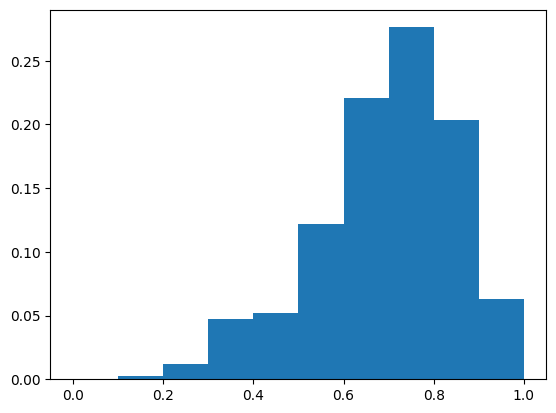

In [18]:
# Your code here to build the magnitude histogram

conditional_magnitude_hist = my_sphere.construct_marginal_magnitude_histogram(
    selected_vectors
)

ax = vr.plotting.produce_1d_scalar_histogram(
    conditional_magnitude_hist, magnitude_bin_edges
)

We can see that our magnitude distribution among the directions we've selected is different from that of all the data! These can reveal interesting insights into the relationship between magnitude and orientation, revealing potentially interesting biological findings!

## Note on Computing Statistics

Up until now, all our analysis have been visual. We've been looking at the magnitude distribution, the bivariate distribution, and the conditional distributions...

But what if we want to get some numerical insights?

Well, the magnitude data are scalars, so we can just analyse both the marginal and conditional magnitude distributions using standard statistics (if the context allows for it).

Similarly, we can just analyse conditional orientation distributions with directional statistics approaches. We saw some of these approaches that are implemented in VectoRose in the previous notebook.

What about the bivariate distribution?

VectoRose can compute the correlation between the orientation and magnitude data. If the two variables are statistically independent, they will not be correlated.

We can compute the correlation using the function [`vr.stats.compute_magnitude_orientation_correlation`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/stats/index.html#vectorose.stats.compute_magnitude_orientation_correlation).

This function returns both the correlation coefficient and the result of the hypothesis test (containing the *p*-value).

As before, we need an array containing our vectors. Unlike previously, these vectors **should not be unit vectors** (otherwise, there won't be any correlation).

We could do this once again with the method [`convert_vectors_to_cartesian_array`](https://vectorose.readthedocs.io/en/latest/autoapi/vectorose/sphere_base/index.html#vectorose.sphere_base.SphereBase.convert_vectors_to_cartesian_array) of the `FineTregenzaSphere`, but we don't have to since we have our **unduplicated** vectors already stored in an array.

In [19]:
# Your code here to compute correlation

correlation_coefficient, hyp_result = vr.stats.compute_magnitude_orientation_correlation(
    vectors
)

print(f"Correlation coefficient: {correlation_coefficient}")
print(f"Test significance: {hyp_result.test_significance}")
print(f"p-value: {hyp_result.p_value}")
print(f"Reject null: {hyp_result.can_reject_null_hypothesis}")

Correlation coefficient: 0.4365647964440926
Test significance: 0.05
p-value: 0.0
Reject null: True


We can see a pretty strong correlation between the magnitude and the orientation, allowing us to reject the null hypothesis that magnitude and orientation are independent.

## Conclusion

We've now reached the end of this notebook on using VectoRose to analyse trabecular anisotropy. Here's a recap of what we saw:

* Using VectoRose, we can examine vectors that have **different magnitudes**.
* We can construct **magnitude histograms** showing the distribution of vector lengths.
* We can construct **bivariate histograms** showing the interplay of magnitude and orientation. We can produce **animations** showing the different histogram shells.
* We can construct **conditional orientation and magnitude histograms** which show the distribution of one variable while filtering based on the other one.
* We can **compute statistics** on the magnitudes and filtered data and compute the **correlation** between magnitude and orientation.

At this point, we've covered the fundamentals of using VectoRose. You should be able to apply VectoRose to studying different collections of vectors, regardless of whether they are of unit or non-unit length.

## Extra Practice

In this notebook, we've been exploring the proximal epiphysis of the mature sheep femur. What about the other end of the bone? I've provided the anisotropy field for the distal epiphysis in the file [`../assets/CaseStudy2/MatureSheepFemur_Distal_S750_R1500_SMOOTH1_EIG_MASKED.npy`](../assets/CaseStudy2/MatureSheepFemur_Distal_S750_R1500_SMOOTH1_EIG_MASKED.npy). Look at it in terms of the magnitude and bivariate distributions, and then explore any interesting features using conditional plots. Does the distal end look different from the proximal end of this bone?

In [20]:
# Your analysis code here


## Additional Resources

Though this is the end of the Bootcamp material, there are more resources out there for learning about VectoRose. Make sure to check out the online documentation at <https://vectorose.readthedocs.io/en/latest/index.html>. This resource contains:

* **API Reference** - explanation of all classes and functions included in VectoRose.
* **User's Guide** - narrative explanations and code examples for using VectoRose.

Make sure to check out the documentation! I wrote it to make it easier for you to learn how to use VectoRose and to explore what you can do with it.

If you have any questions, feel free to reach out to me. If you find any software bugs, please open an issue on [GitHub](https://github.com/bzrudski/vectorose).

Thank you very much for your participation!